In [1]:
import pandas as pd
import os 
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdmolfiles import  MolFromXYZFile
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem import rdFMCS
import rdkit
import networkx as nx
import torch
import re
import matplotlib.pyplot as plt
import copy
rdkit.__version__


'2023.03.1'

In [2]:
def spectrum(E,osc,sigma,x):
    gE=[]
    for Ei in x:
        tot=0
        for Ej,os in zip(E,osc):
            tot+=os*np.exp(-((((Ej-Ei)/sigma)**2)))
        gE.append(tot)
    return gE

In [3]:
def count_atoms(mol,atomic_num):
    #Works for all atoms, input atomic_num
    num_oxygens = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == atomic_num:  # Atomic number 8 corresponds to oxygen
            num_oxygens += 1
    return num_oxygens

In [4]:
def plot_spectrum(x,gE,spec_dest) -> None:
    
    
    fig, ax = plt.subplots()
    ax.plot(x, gE, color='k',alpha=0.4, linewidth=0.8)
    ax.set_xlim(280, 300)
    ax.set_xlabel('Energy')
    ax.set_ylabel('Intensity')
    ax.set_title('Spectra')
    plt.savefig(spec_dest)
    plt.close()
                
                
    

In [5]:
def symm_atoms(mol) -> None:

    Chem.AssignStereochemistry(mol,cleanIt=True,force=True,flagPossibleStereoCenters=True)
    t=[[atom.GetIdx(),atom.GetProp('_CIPRank')]for atom in mol.GetAtoms()]
    symm_dict={}
    for atom in mol.GetAtoms():
        symm_dict[atom.GetIdx()]=atom.GetProp('_CIPRank')
   
    # Print the symmetric carbons
   # print("Symmetric carbons:")
   # print(symm_dict)
    
    return symm_dict

                    


In [6]:
#define a function to take folders and make networkx graphs
def graph_maker(main_dir,plot_var=0):
    
    #cmap = plt.get_cmap('viridis')
    #initialise certain variables
    x=np.linspace(280,300, num=200, endpoint=True)
    sigma=0.6
    
    #List of files in the directory. need this to get the optimised xyz coordinate
    files = [f for f in os.listdir(main_dir) if os.path.isfile(os.path.join(main_dir, f))]
    #print(files)
    
    #find the file with the OPT_x.xyz name
    pattern = r'^OPT_[\w]+\.xyz$'
    
    for filename in files:
        if re.match(pattern, filename):
            xyz_name=filename
            break
    
    #make the path of the xyz file
    xyz_path=main_dir+'/'+xyz_name
    
    #make a mol object from the xyz file
    
    raw_mol = MolFromXYZFile(xyz_path)
    conn_mol = Chem.Mol(raw_mol)
    rdDetermineBonds.DetermineBonds(conn_mol)
    mol = copy.deepcopy(conn_mol)
    mol = Chem.RemoveAllHs(mol)
   
    Chem.RemoveStereochemistry(mol)
    smi = Chem.MolToSmiles(mol)
   
    #print(smi)
    px=symm_atoms(mol)
    
        
    for i, atom in enumerate(mol.GetAtoms()):
        #For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
        atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))
        #atom.SetProp("molAtomMapNumber", str(px[i]))
    
    #display(mol)
    count_ox=count_atoms(mol,8)
    
    #look now at the subdirectories that contain the local spectra
    loc_dirs = [os.path.join(main_dir, d) for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]
    loc_names=[f for f in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, f))]
    name_dirs=[x[1] for x in os.walk(main_dir)][0]
    #print(loc_names)
    
    #t_num={}
    #for i, atom in enumerate(mol.GetAtoms()):
        #For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
     #   t_num[atom.GetProp("molAtomMapNumber")]=atom.GetIdx()
    #print(t_num)
    
    #loop through each directory and get the spectrum file / make a dataframes for the spectra
    spec_dict={}
    for i in range(len(loc_dirs)) :
        loc_dir=loc_dirs[i]
        #name_dir=name_dirs[i]
        loc_files=[f for f in os.listdir(loc_dir) if os.path.isfile(os.path.join(loc_dir, f))]
        dict_ind=str(int(loc_names[i])-count_ox)
    
       # print(loc_dir,loc_files,name_dir)
        #color = cmap(i / len(loc_dirs))
        
        symm_dict={}
        for filename in loc_files:
        
           # print(loc_folders)
            if filename.endswith('.abs.stk'):
                spec_df= pd.read_csv(loc_dir+"/"+filename, sep='\s+', header=None, names=['Peak', 'Strength'])
                #make spectrum array
                
                energies=spec_df['Peak']
                osc=spec_df['Strength']
                gE=spectrum(energies,osc,sigma,x)
                spec_dict[dict_ind]=gE
                
                #print(int(dict_ind),mol.GetAtomWithIdx(int(dict_ind)).GetAtomicNum())
                #print([[x.GetIdx(),x.GetAtomicNum()] for x in mol.GetAtomWithIdx(int(dict_ind)).GetNeighbors()])
                
                if plot_var==1 :
                    #print('Now plotting spectra')
                    dest_name='E:/comp_spec/'+filename+'_'+dict_ind+'_spectrum.jpg'
                    plot_spectrum(x,gE,dest_name)
                    
    return mol,spec_dict
    

In [7]:
folder_path='E:/XAS_dataset/Coronene/Coronene_spectra/set_tot/OPT_output'
subdirs = [os.path.join(folder_path, d) for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

In [8]:
spec_list={}
mol_list={}
smile_list={}

for subdir in subdirs:
    dirpath, foldername = os.path.split(subdir)
    plot_var = 1

    try:
        m1, m1_spec = graph_maker(subdir, plot_var)
        count_c = count_atoms(m1, 6)
        
        if len(m1_spec.keys()) == count_c:
            spec_list[foldername] = m1_spec
            mol_list[foldername] = Chem.MolToSmiles(m1)
        else:
            print('Molecule invalid:', subdir)
    except Exception as e:
        print('Error occurred in graph_maker:', str(e))




In [9]:
import json

In [10]:
sm2=mol_list['R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_1_1']

In [ ]:
from rdkit.Chem import Draw
atom_index=0
# Generate a highlighted image of the molecule
highlighted_mol = Draw.MolToImage(mol, highlightAtoms=[atom_index])

# Display the image
highlighted_mol.show()

In [99]:
m1 = Chem.MolFromSmiles(sm2)

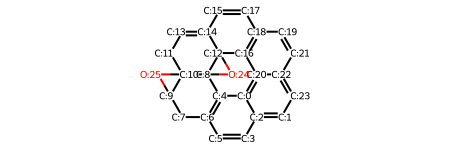

In [100]:
display(m1)

In [59]:
sm1=mol_list['R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2']

In [56]:
spec_list['R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_3_2'].keys()

dict_keys(['7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '0', '1', '2', '3', '4', '5', '6'])

In [60]:
m = Chem.MolFromSmiles(sm1)

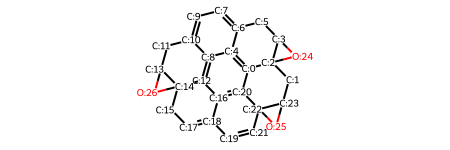

In [61]:
display(m)

In [66]:
for atom in range(0,27):
    neighbours_dict[atom]= [[(m.GetAtomWithIdx(atom)).GetProp("molAtomMapNumber"),x.GetProp("molAtomMapNumber"),x.GetIdx()] for x in m.GetAtomWithIdx(atom).GetNeighbors()]

In [67]:
neighbours_dict

{0: [['0', '4', 1], ['0', '20', 9], ['0', '2', 22]],
 1: [['4', '0', 0], ['4', '6', 2], ['4', '8', 6]],
 2: [['6', '4', 1], ['6', '7', 3], ['6', '5', 24]],
 3: [['7', '6', 2], ['7', '9', 4]],
 4: [['9', '7', 3], ['9', '10', 5]],
 5: [['10', '9', 4], ['10', '8', 6], ['10', '11', 18]],
 6: [['8', '10', 5], ['8', '12', 7], ['8', '4', 1]],
 7: [['12', '8', 6], ['12', '16', 8], ['12', '14', 16]],
 8: [['16', '12', 7], ['16', '20', 9], ['16', '18', 13]],
 9: [['20', '16', 8], ['20', '22', 10], ['20', '0', 0]],
 10: [['22', '20', 9], ['22', '21', 11], ['22', '23', 20], ['22', '25', 26]],
 11: [['21', '22', 10], ['21', '19', 12]],
 12: [['19', '21', 11], ['19', '18', 13]],
 13: [['18', '19', 12], ['18', '17', 14], ['18', '16', 8]],
 14: [['17', '18', 13], ['17', '15', 15]],
 15: [['15', '17', 14], ['15', '14', 16]],
 16: [['14', '15', 15], ['14', '13', 17], ['14', '12', 7], ['14', '26', 19]],
 17: [['13', '14', 16], ['13', '11', 18], ['13', '26', 19]],
 18: [['11', '13', 17], ['11', '10', 5]],

In [68]:
m.GetAtomWithIdx(19).GetAtomicNum()

8

In [ ]:
x=spec_list['R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_1_1'].keys()
high=[int(t) for t in x]

In [ ]:
from rdkit.Chem import Draw
atom_index=0
# Generate a highlighted image of the molecule
highlighted_mol = Draw.MolToImage(mol, highlightAtoms=high)

# Display the image
highlighted_mol.show()

In [11]:
import pickle 

input_list=[mol_list,spec_list]

with open("E:/hlrn_orca/input.pkl", "wb") as file:
    pickle.dump(input_list, file)

In [12]:
filename = "E:/hlrn_orca/data_coronene_4sets_0.6.json"
with open(filename, "w") as file:
    json.dump(input_list, file)


In [ ]:
# Aromatize the molecule
Chem.SanitizeMol(m1, Chem.SanitizeFlags.AROMATIC)

# Get the aromatized SMILES string
aromatized_smiles = Chem.MolToSmiles(m1)

#print("Aromatized SMILES:", aromatized_smiles)
Chem.Kekulize(m1)

In [ ]:
len(input_list[0])

In [ ]:
rdkit.Chem.Draw.MolToImage(m1, size=(300, 300), kekulize=True, wedgeBonds=True, fitImage=False, options=None, canvas=None)

In [20]:
sm1='[C:0]123[C:2]4=[CH:3][CH:6]=[C:7]5[C:5]1([C:9]16[C:11](=[CH:12][CH:14]=[C:15]7[C:13]1([C:17]18[C:19]([CH:18]=[CH:16]7)([CH:20]=[C:22]([OH:25])[C:23](=[C:21]21)[CH:24]=[C:1]4[OH:4])[O:26]8)[O:28]6)[CH:10]=[CH:8]5)[O:27]3'
m = Chem.MolFromSmiles(sm1)
res = list(BRICS.BRICSDecompose(m))
sorted(res)

['[C:0]123[C:2]4=[CH:3][CH:6]=[C:7]5[C:5]1([C:9]16[C:11](=[CH:12][CH:14]=[C:15]7[C:13]1([C:17]18[C:19]([CH:18]=[CH:16]7)([CH:20]=[C:22]([OH:25])[C:23](=[C:21]21)[CH:24]=[C:1]4[OH:4])[O:26]8)[O:28]6)[CH:10]=[CH:8]5)[O:27]3']

In [42]:
atoms=[]
neighbours_dict={}
for atom in range(0,25):
    neighbours_dict[atom]= [[(m.GetAtomWithIdx(atom)).GetProp("molAtomMapNumber"),x.GetProp("molAtomMapNumber"),x.GetIdx()] for x in m.GetAtomWithIdx(atom).GetNeighbors()]

In [43]:
neighbours_dict

{0: [['0', '2', 1], ['0', '5', 5], ['0', '21', 20], ['0', '27', 28]],
 1: [['2', '0', 0], ['2', '3', 2], ['2', '1', 22]],
 2: [['3', '2', 1], ['3', '6', 3]],
 3: [['6', '3', 2], ['6', '7', 4]],
 4: [['7', '6', 3], ['7', '5', 5], ['7', '8', 27]],
 5: [['5', '7', 4], ['5', '9', 6], ['5', '27', 28], ['5', '0', 0]],
 6: [['9', '5', 5], ['9', '11', 7], ['9', '13', 11], ['9', '28', 25]],
 7: [['11', '9', 6], ['11', '12', 8], ['11', '10', 26]],
 8: [['12', '11', 7], ['12', '14', 9]],
 9: [['14', '12', 8], ['14', '15', 10]],
 10: [['15', '14', 9], ['15', '13', 11], ['15', '16', 15]],
 11: [['13', '15', 10], ['13', '17', 12], ['13', '28', 25], ['13', '9', 6]],
 12: [['17', '13', 11], ['17', '19', 13], ['17', '21', 20], ['17', '26', 24]],
 13: [['19', '17', 12], ['19', '18', 14], ['19', '20', 16], ['19', '26', 24]],
 14: [['18', '19', 13], ['18', '16', 15]],
 15: [['16', '18', 14], ['16', '15', 10]],
 16: [['20', '19', 13], ['20', '22', 17]],
 17: [['22', '20', 16], ['22', '25', 18], ['22', '23'

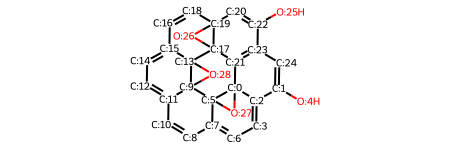

In [36]:
display(m)

In [37]:
# Remove hydrogen atoms
Chem.RemoveStereochemistry(mol)
mol = Chem.RemoveAllHs(m1)

# Get the SMILES string without hydrogens
smiles_no_hydrogens = Chem.MolToSmiles(mol)

print("SMILES without hydrogens:", smiles_no_hydrogens)

NameError: name 'mol' is not defined

In [ ]:
print(m1==m )

In [ ]:
ATOM_FEATURES = {
            'atomic_num': [1,6,8],
            'degree': [0, 1, 2, 3, 4],
           # 'formal_charge': [-1, -2, 1, 2, 0],
            'chiral_tag': [0, 1, 2, 3],
            'num_Hs': [0, 1, 2, 3, 4],
            'hybridization': [
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3
                ],
            }

ATOM_FDIM=sum(len(choices)  for choices in ATOM_FEATURES.values()) + 1

In [ ]:
ATOM_FDIM